### Importing libraries and datasets

In [ ]:
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from thefuzz import fuzz

nltk.download('punkt')

In [2]:
responses = pd.read_csv('../data/responses.csv')
test = pd.read_csv('../data/test.csv')

In [3]:
print(responses.shape, test.shape)

(30, 3) (10, 2)


In [4]:
responses.sample(5)

,response,duration,model
12,The topic of discussion in the meeting was the...,6.890072,gpt-4
1,The topic discussed in the meeting was the rec...,8.482788,gpt-3.5-turbo
20,"According to the text, there were two partici...",6.005944,llama-2
16,The key moments of the recent Cricket World Cu...,7.601231,gpt-4
6,One key moment in the match between Pakistan a...,11.843327,gpt-3.5-turbo


In [5]:
test.sample(3)

,question,answer
7,Which team won the match and by how many runs?,Pakistan won the match by 21 runs.
1,What was the topic for the meeting?,The topic of the meeting was the recent ODI ma...
6,What were the key moments for the match?,A few key moments of the match included Waseem...


### EDA and Pre-processing

In [6]:
df = responses.copy()
df.shape

(30, 3)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   response  30 non-null     object 
 1   duration  30 non-null     float64
 2   model     30 non-null     object 
dtypes: float64(1), object(2)
memory usage: 852.0+ bytes


In [8]:
df.describe(include='all')

,response,duration,model
count,30,30.000000,30
unique,30,NaN,3
top,The names of the three participants in the mee...,NaN,gpt-3.5-turbo
freq,1,NaN,10
mean,NaN,8.958058,NaN
std,NaN,4.035647,NaN
min,NaN,3.138263,NaN
25%,NaN,6.499391,NaN
50%,NaN,7.644105,NaN
75%,NaN,10.395783,NaN


Dealing with outliers using IQR

In [9]:
def filter_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    return data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR)))]

In [10]:
df['duration'] = filter_outliers_iqr(df['duration'])

In [11]:
df['duration'].describe()

count    27.000000
mean      7.870720
std       2.325825
min       3.138263
25%       6.408058
50%       7.212238
75%       9.541978
max      12.798496
Name: duration, dtype: float64

In [12]:
df.isnull().sum()

response    0
duration    3
model       0
dtype: int64

In [13]:
df = df.dropna()

In [14]:
df.shape

(27, 3)

In [15]:
df.duplicated().sum()

0

Adding extra features for analysis

In [16]:
df['num_chars'] = df['response'].apply(len)
df['num_words'] = df['response'].apply(lambda x:len(nltk.word_tokenize(x)))
df['num_sentences'] = df['response'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [17]:
df.shape

(27, 6)

Rounding the duration column to 2 decimal places

In [18]:
df['duration'] = df['duration'].round(2)

In [19]:
df.sample(5)

,response,duration,model,num_chars,num_words,num_sentences
21,"Based on the conversation provided, the topic...",11.09,llama-2,256,42,1
1,The topic discussed in the meeting was the rec...,8.48,gpt-3.5-turbo,111,20,1
11,Three individuals participated in the meeting ...,6.52,gpt-4,165,30,2
12,The topic of discussion in the meeting was the...,6.89,gpt-4,247,45,2
16,The key moments of the recent Cricket World Cu...,7.60,gpt-4,236,42,1


Visualizing the correlation between columns

In [20]:
df.corr(numeric_only=True)

,duration,num_chars,num_words,num_sentences
duration,1.000000,0.499883,0.465480,0.134628
num_chars,0.499883,1.000000,0.991193,0.468770
num_words,0.465480,0.991193,1.000000,0.529642
num_sentences,0.134628,0.468770,0.529642,1.000000


### Evaluation over Duration and Density metrics.

Calculating mean duration, num_chars and num_words for each model.

In [21]:
df.groupby('model').mean(numeric_only=True)

,duration,num_chars,num_words,num_sentences
model,,,,
gpt-3.5-turbo,10.120,154.428571,28.428571,1.285714
gpt-4,6.093,164.000000,30.800000,1.600000
llama-2,8.075,158.900000,29.100000,1.100000


In [22]:
fig = px.scatter_matrix(df,
                        title='Scatter matrix of chatbot responses',
                        dimensions=['duration', 'num_chars', 'num_words'],
                        color='model')
fig.show()

Plotting time taken for each response to generate for each model with respect to the number of characters in each response.

In [23]:
fig = px.scatter(df,
                 x='duration',
                 y='num_chars',
                 color='model',
                 title='Number of characters vs Time (s)',
                 labels={'num_chars': 'Number of characters', 'duration': 'Time (s)'})

fig.update_layout(height=400, width=600)
fig.show()

Plotting the regression line to show linearity in the above plot.

In [28]:
fig = px.scatter(df,
                 x='duration',
                 y='num_chars',
                 trendline='ols',
                 title='Regression plot',
                 labels={'num_chars': 'Number of characters', 'duration': 'Time (s)'})

fig.update_layout(height=400, width=600)
fig.show()

Plotting the density of each response for each model based on the number of characters in each response.

In [29]:
fig = px.histogram(df, x='num_chars', color='model', nbins=30, opacity=0.7,
                   title='Response Density (num_chars)',
                   labels={'num_chars': 'Number of Characters'})

fig.update_layout(height=400, width=600, bargap=0.1)
fig.show()

Plotting kernel density of model responses.

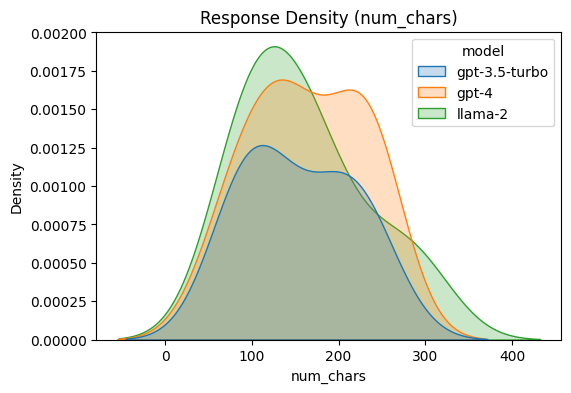

In [30]:
plt.figure(figsize=(6, 4))
sns.kdeplot(data=df,
            x='num_chars',
            fill=True,
            hue='model')
plt.title('Response Density (num_chars)')
plt.show()

### Evaluation using the Levenshtein distance.

Creating our own class to calculate the Levenshtein distance between two strings.

In [55]:
class Levenshtein_Distance:
  def __init__(self):
    pass

  def min_distance(self, word1, word2):
    dp = [[0 for i in range(len(word1) + 1)] for j in range(len(word2) + 1)]

    for i in range(len(dp)):
      dp[i][0] = i

    for i in range(len(dp[0])):
      dp[0][i] = i

    for i in range(len(dp)):
      for j in range(len(dp[0])):
        if word1[j - 1] == word2[i - 1]:
          dp[i][j] = dp[i - 1][j - 1]
        else:
          dp[i][j] = min(dp[i - 1][j - 1], dp[i - 1][j], dp[i][j - 1]) + 1

    return dp[len(dp) - 1][len(dp[0]) - 1]

Initilizing the `Levenstein_Distance` class object.

In [36]:
lev_dist = Levenshtein_Distance()

In [38]:
gpt_4_responses = df[df['model'] == 'gpt-4']['response']
gpt_3_5_responses = df[df['model'] == 'gpt-3.5-turbo']['response']
llama_2_responses = df[df['model'] == 'llama-2']['response']

In [39]:
test_responses = test['answer']

Creating a function that takes responses from each series, calculates the Levenshtein distance and returns the mean score value.

In [41]:
def get_mean_score(series1, series2):
  scores = []

  for response1, response2 in zip(series1, series2):
    score = lev_dist.min_distance(response1, response2)
    scores.append(score)

  return sum(scores)/len(scores)

In [42]:
gpt_4_score = get_mean_score(gpt_4_responses, test_responses)
gpt_3_5_score = get_mean_score(gpt_3_5_responses, test_responses)
llama_2_score = get_mean_score(llama_2_responses, test_responses)

In [43]:
print(gpt_4_score, gpt_3_5_score, llama_2_score, sep='\n')

68.6
61.142857142857146
60.2


Visualizing the scores.

In [52]:
fig = px.bar(y=[gpt_4_score, gpt_3_5_score, llama_2_score],
             x=['gpt-4', 'gpt-3.5-turbo', 'llama-2'],
             labels={'y':'Distance', 'x':'Model'}, 
             title='Mean Levenshtein Scores (Custom class)')
fig.update_layout(height=400, width=600)
fig.show()

Calculating Levenshtein distance by using the `thefuzz` library

In [49]:
def get_mean_score(series1, series2):
  scores = []

  for response1, response2 in zip(series1, series2):
    score = fuzz.ratio(response1, response2)
    scores.append(score)

  return sum(scores)/len(scores)

In [50]:
gpt_4_score = get_mean_score(gpt_4_responses, test_responses)
gpt_3_5_score = get_mean_score(gpt_3_5_responses, test_responses)
llama_2_score = get_mean_score(llama_2_responses, test_responses)

In [51]:
print(gpt_4_score, gpt_3_5_score, llama_2_score, sep='\n')

56.1
42.857142857142854
55.3


Visualizing the scores.

In [54]:
fig = px.bar(y=[gpt_4_score, gpt_3_5_score, llama_2_score],
             x=['gpt-4', 'gpt-3.5-turbo', 'llama-2'],
             labels={'y':'Distance', 'x':'Model'}, 
             title='Mean Levenshtein Scores (thefuzz library)')
fig.update_layout(height=400, width=600)
fig.show()